[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

## Download Kaggle Data

Uncomment the below function to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [ ]:
def download_kaggle_data():
    from google.colab import userdata
    import os

    os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
    os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

    !kaggle competitions download -c store-sales-time-series-forecasting

    ! unzip "store-sales-time-series-forecasting.zip" -d data

download_kaggle_data()

store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  store-sales-time-series-forecasting.zip
replace data/holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install sktime[all_extras]

In [ ]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')

## Datasets

The datasets provided by Kaggle include:

* **train.csv**
* **test.csv**
* **transactions.csv**
* **stores.csv**
* **holiday_events.csv**
* **oil.csv**


**Additional Notes**

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Features:

* *date*: Date of entry
* *store_nbr*: Store Number
* *family*: Product Family
* *onpromotion*: Items in a product family being promoted at a store at a given date.
* *sales (Target variable)*: Total sales for a product family at a particular store at a given date.
* *cluster*: Grouping of similar stores
* *type*: Type of Store
* *city*: City
* *state*: State the store is located in
* *holiday_type & locale* : If it was a holiday and type of holiday
* *transactions*: Number of transactions

In [ ]:
# Dtype for loading datasets
dtype = {
    'store_nbr': 'int64',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',

    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}


### 1. `store_sales`

 Dataset: **train.csv**

The training data, comprising time series of features. Columns include:

- **store_nbr** - identifies the 54 different stores at which the products are being sold at.
- **family** - identifies the type of products sold (books, automobile, dairy , eggs ,etc..)
- **onpromotion** - shows the total amount of items the were being promoted at a store on a given date in a specific product family.
- **sales (target)** - describes the total sales per product family at a given store on a given date. to ...

In [ ]:
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)
store_sales["date"] = store_sales["date"].dt.to_period('D')

In [ ]:
# dataset overview
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype    
---  ------       -----    
 0   id           int64    
 1   date         period[D]
 2   store_nbr    int64    
 3   family       category 
 4   sales        float32  
 5   onpromotion  uint64   
dtypes: category(1), float32(1), int64(2), period[D](1), uint64(1)
memory usage: 105.9 MB


In [ ]:
store_sales

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0
1,1,2013-01-01,1,BABY CARE,0.000000,0
2,2,2013-01-01,1,BEAUTY,0.000000,0
3,3,2013-01-01,1,BEVERAGES,0.000000,0
4,4,2013-01-01,1,BOOKS,0.000000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8


### Analysis on `store_sales`:

**Columns**:
- *store_nbr* - identifies the 54 different stores at which the products are being sold at.
- *family* - identifies the type of products sold (books, automobile, dairy , eggs ,etc..)
- *onpromotion* - shows the total amount of items the were being promoted at a store on a given date in a specific product family.
- *sales (target)* - describes the total sales per product family at a given store on a given date.
  
**Index columns**:
- date
- store_nbr
- family

**Rows**

* Rows highlight measurement at that "date", in store with "store_nbr", for product family "family"

**Observations**

* there are 3.000.887 rows in total
* there are 33 distinct product families (family) in total, such as AUTOMOTIV, POULTRY
* there are 54 store_nbr in total, ranging over all integers from 1 to 54. They have the same 33 distinct product families
* there are 765 distinct dates in total, ranging from 2013-01-01 to 2017-08-15 (5+ years)
* There is a positive correlation between the Promoted product families and families making the most sales. There is also a positive correlation between the Promoted stores and stores making the most sales. These highlights the promotions has a significant on Favorita's sales.

### Hierarchical Time Series

* Sktime supports hierarchical representations of data using the pandas multi-index functionality.

In [80]:
# import to retrieve examples

from sktime.datatypes import get_examples

get_examples(mtype="pd_multiindex_hier")[1]

var_0
foo bar timepoints       
a   0   0               1
        1               2
        2               3
    1   0               1
        1               2
        2               3
    2   0               1
        1               2
        2               3
b   0   0               1
        1               2
        2               3
    1   0               1
        1               2
        2               3
    2   0               1
        1               2
        2               3

In [53]:
# Target
y = store_sales.groupby(['store_nbr', 'family', 'date']).mean()["sales"].to_frame()
y

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0
...                                ...
54        SEAFOOD    2017-08-11    0.0
                     2017-08-12    1.0
                     2017-08-13    2.0
                     2017-08-14    0.0
                     2017-08-15    3.0

[3000888 rows x 1 columns]

In [54]:
from sktime.transformations.hierarchical.aggregate import Aggregator

y = Aggregator().fit_transform(y)
y

sales
store_nbr family     date                   
1         AUTOMOTIVE 2013-01-01       0.0000
                     2013-01-02       2.0000
                     2013-01-03       3.0000
                     2013-01-04       3.0000
                     2013-01-05       5.0000
...                                      ...
__total   __total    2017-08-11  826373.7500
                     2017-08-12  792630.5625
                     2017-08-13  865639.6875
                     2017-08-14  760922.4375
                     2017-08-15  762661.9375

[3093508 rows x 1 columns]

In [55]:
from sktime.forecasting.model_selection import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=16)

test_fh = y_test.index.get_level_values(-1).unique()
test_fh

PeriodIndex(['2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03',
             '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07',
             '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
             '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date')

In [56]:
y_train

sales
store_nbr family     date                    
1         AUTOMOTIVE 2013-01-01  0.000000e+00
                     2013-01-02  2.000000e+00
                     2013-01-03  3.000000e+00
                     2013-01-04  3.000000e+00
                     2013-01-05  5.000000e+00
...                                       ...
__total   __total    2017-07-26  7.406531e+05
                     2017-07-27  6.598498e+05
                     2017-07-28  8.350997e+05
                     2017-07-29  1.032311e+06
                     2017-07-30  1.123752e+06

[3064116 rows x 1 columns]

In [57]:
y_test

sales
store_nbr family     date                   
1         AUTOMOTIVE 2017-07-31       8.0000
                     2017-08-01       5.0000
                     2017-08-02       4.0000
                     2017-08-03       3.0000
                     2017-08-04       8.0000
...                                      ...
__total   __total    2017-08-11  826373.7500
                     2017-08-12  792630.5625
                     2017-08-13  865639.6875
                     2017-08-14  760922.4375
                     2017-08-15  762661.9375

[29392 rows x 1 columns]

In [58]:
def plot_series_for_given_level(selected_first_level, y_train, y_test, forecasts=None):

    y_column_name = y_train.columns[0]
    second_level_values = (
        y_train.loc[selected_first_level].index.get_level_values(0).unique()
    )

    # Create subplots
    fig, axs = plt.subplots(
        nrows=int(np.ceil(len(second_level_values) / 2)),
        ncols=2,
        figsize=(12, 1.5 * len(second_level_values)),
    )

    y_train_selected = y_train.loc[selected_first_level]
    y_test_selected = y_test.loc[selected_first_level]

    if forecasts is not None:
        forecasts_selected = {
            k: forecast.loc[selected_first_level] for k, forecast in forecasts.items()
        }

    # Plot each purpose and remove empty subplots in one loop
    for ax, level_value in zip(axs.flatten(), second_level_values):
        y_train_selected.loc[level_value][y_column_name].rename("Train").plot(
            ax=ax, legend=True
        )
        y_test_selected.loc[level_value][y_column_name].rename("Test").plot(
            ax=ax, legend=True
        )

        if forecasts is not None:
            for name, forecast in forecasts_selected.items():
                forecast.loc[level_value][y_column_name].rename(name).plot(
                    ax=ax, legend=True
                )

        ax.set_title(level_value)

    # Remove empty subplots
    for ax in axs.flatten()[len(second_level_values) :]:
        fig.delaxes(ax)

    fig.suptitle(selected_first_level)

    fig.tight_layout()
    plt.show()


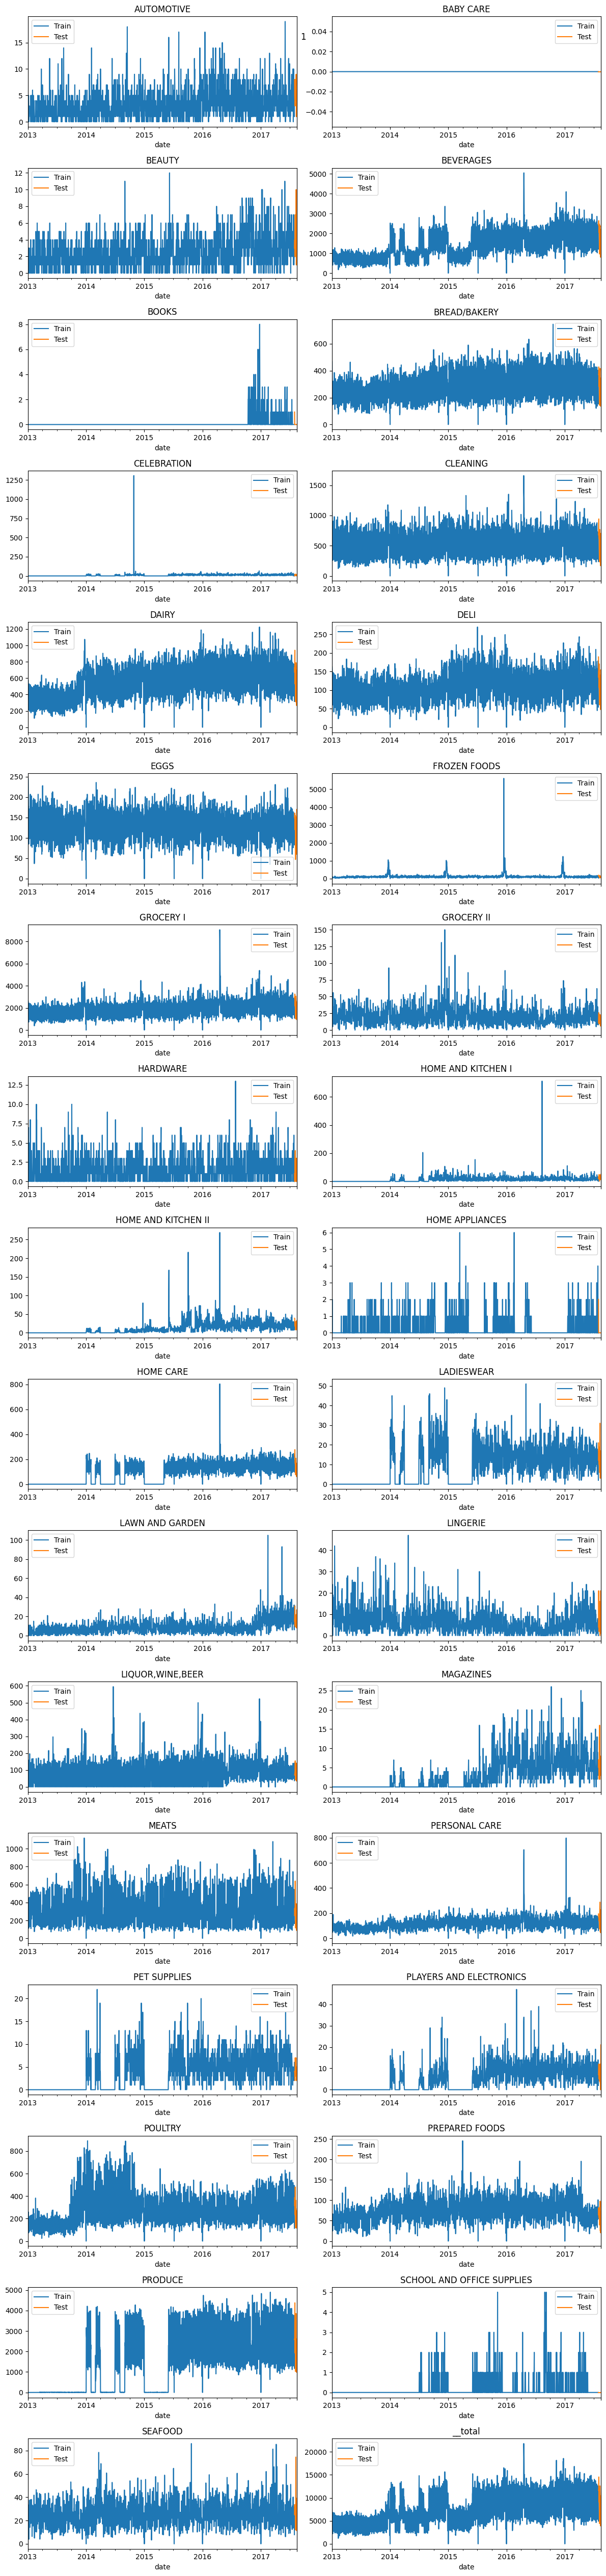

In [59]:
plot_series_for_given_level(1, y_train, y_test)

## Initial Modelling

Many transformers and forecasters implemented for single series

sktime automatically vectorizes/”up-casts” them to hierarchical data

“apply by individual series/panel in the hierarchical structure”

constructing a hierarchical time series:

In [60]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.fbprophet import Prophet

import logging

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [69]:
# Warning: this cell may take 1-2 minutes to run!
model = Prophet()

model.fit(y_train)
model.predict(fh=test_fh)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


sales
store_nbr family     date                    
1         AUTOMOTIVE 2017-07-31  4.684985e+00
                     2017-08-01  5.252210e+00
                     2017-08-02  4.878986e+00
                     2017-08-03  4.369521e+00
                     2017-08-04  5.086712e+00
...                                       ...
__total   __total    2017-08-11  7.643977e+05
                     2017-08-12  9.570907e+05
                     2017-08-13  1.012275e+06
                     2017-08-14  8.039386e+05
                     2017-08-15  7.583847e+05

[29392 rows x 1 columns]

In [70]:
# With parallelization

In [71]:
# parallel_config = {
#         "backend:parallel": "joblib",
#         "backend:parallel:params": {"backend": "loky", "n_jobs": -1},
#     }

In [72]:
# model = Prophet()

# model.set_config(**parallel_config)

# model.fit(y_train)

In [73]:
y_pred = model.predict(fh=test_fh)
y_pred

sales
store_nbr family     date                    
1         AUTOMOTIVE 2017-07-31  4.684985e+00
                     2017-08-01  5.252210e+00
                     2017-08-02  4.878986e+00
                     2017-08-03  4.369521e+00
                     2017-08-04  5.086712e+00
...                                       ...
__total   __total    2017-08-11  7.643977e+05
                     2017-08-12  9.570907e+05
                     2017-08-13  1.012275e+06
                     2017-08-14  8.039386e+05
                     2017-08-15  7.583847e+05

[29392 rows x 1 columns]

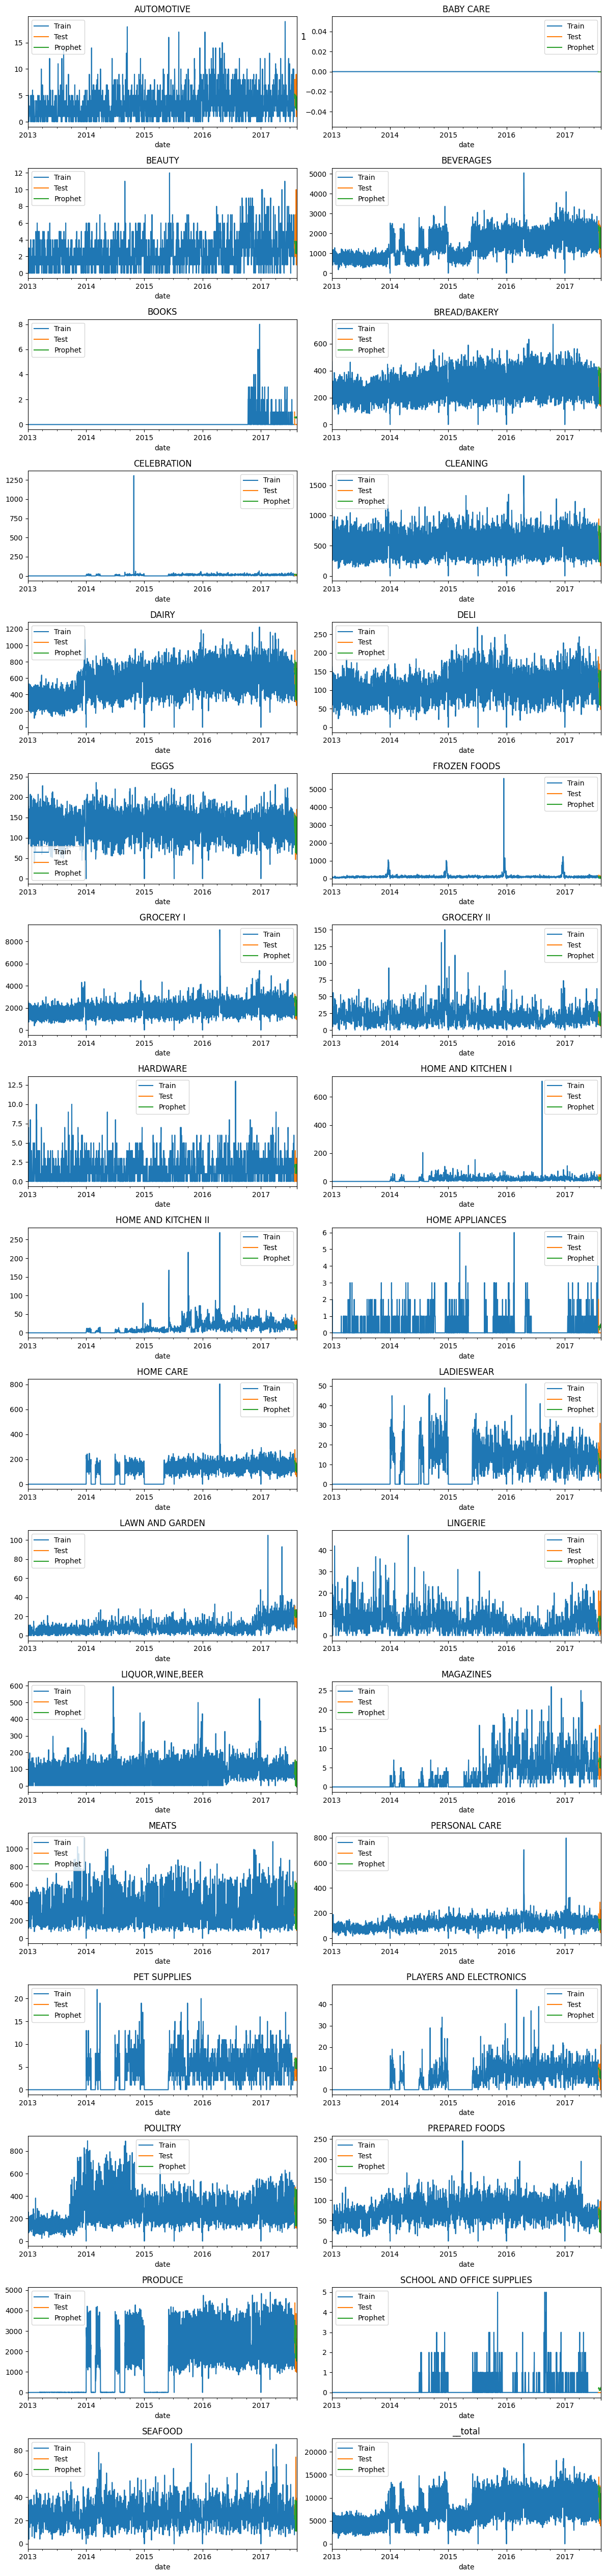

In [74]:
plot_series_for_given_level(1, y_train, y_test, {"Prophet" : y_pred})

In [75]:
sum((y_test["sales"] - y_pred["sales"])**2) / len(y_test)

5027013.835514244

In [81]:
def get_difference_between_total_and_bottom_up(y_pred):
    bottom_up = (
        Aggregator().fit_transform(y_pred).loc[("__total", "__total"), "sales"]
    )
    total_forecast = y_pred.loc[("__total", "__total"), "sales"]
    difference = total_forecast - bottom_up
    return difference

get_difference_between_total_and_bottom_up(y_pred).head()

,sales
date,
2017-07-31,-8775.035069
2017-08-01,-8936.506048
2017-08-02,-9101.841555
2017-08-03,-9271.159226
2017-08-04,-9431.827679


In [82]:
from sktime.transformations.hierarchical.reconcile import Reconciler

reconciler = Reconciler()
y_pred_reconciled = reconciler.fit_transform(y_pred)
y_pred_reconciled.head()

sales
store_nbr family     date                
1         AUTOMOTIVE 2017-07-31  4.684985
                     2017-08-01  5.252210
                     2017-08-02  4.878986
                     2017-08-03  4.369521
                     2017-08-04  5.086712

In [83]:
get_difference_between_total_and_bottom_up(y_pred_reconciled).head()

,sales
date,
2017-07-31,-1.280569e-09
2017-08-01,2.328306e-10
2017-08-02,-8.149073e-10
2017-08-03,-1.164153e-09
2017-08-04,-2.328306e-10


In [87]:
from sktime.performance_metrics.forecasting import MeanSquaredError

metric = MeanSquaredError()
metric(y_true=y_test, y_pred=y_pred_reconciled)

5052834.387062302

In [89]:
# Already available exogeneous data
X = store_sales.groupby(['store_nbr', 'family', 'date']).mean()["onpromotion"].to_frame()
X

onpromotion
store_nbr family     date                   
1         AUTOMOTIVE 2013-01-01          0.0
                     2013-01-02          0.0
                     2013-01-03          0.0
                     2013-01-04          0.0
                     2013-01-05          0.0
...                                      ...
54        SEAFOOD    2017-08-11          0.0
                     2017-08-12          1.0
                     2017-08-13          0.0
                     2017-08-14          0.0
                     2017-08-15          0.0

[3000888 rows x 1 columns]

In [101]:
from sktime.transformations.hierarchical.aggregate import Aggregator

X = Aggregator().fit_transform(X)
X

onpromotion
store_nbr family     date                   
1         AUTOMOTIVE 2013-01-01          0.0
                     2013-01-02          0.0
                     2013-01-03          0.0
                     2013-01-04          0.0
                     2013-01-05          0.0
...                                      ...
__total   __total    2017-08-11      14179.0
                     2017-08-12       8312.0
                     2017-08-13       9283.0
                     2017-08-14       8043.0
                     2017-08-15      10605.0

[3093508 rows x 1 columns]

In [102]:
X_train, X_test = temporal_train_test_split(X, test_size=16)

In [103]:
X_train

onpromotion
store_nbr family     date                   
1         AUTOMOTIVE 2013-01-01          0.0
                     2013-01-02          0.0
                     2013-01-03          0.0
                     2013-01-04          0.0
                     2013-01-05          0.0
...                                      ...
__total   __total    2017-07-26      18725.0
                     2017-07-27       8001.0
                     2017-07-28      13850.0
                     2017-07-29       9099.0
                     2017-07-30      10227.0

[3064116 rows x 1 columns]

In [104]:
X_test

onpromotion
store_nbr family     date                   
1         AUTOMOTIVE 2017-07-31          0.0
                     2017-08-01          0.0
                     2017-08-02          0.0
                     2017-08-03          0.0
                     2017-08-04          0.0
...                                      ...
__total   __total    2017-08-11      14179.0
                     2017-08-12       8312.0
                     2017-08-13       9283.0
                     2017-08-14       8043.0
                     2017-08-15      10605.0

[29392 rows x 1 columns]

In [106]:
# Warning: this cell may take 1-2 minutes to run!
model = Prophet()

model.fit(y=y_train, X=X_train)
y_pred = model.predict(X=X_test, fh=test_fh)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


sales
store_nbr family     date                     
1         AUTOMOTIVE 2017-07-31       4.728044
                     2017-08-01       5.293555
                     2017-08-02       4.923126
                     2017-08-03       4.419014
                     2017-08-04       5.136996
...                                        ...
__total   __total    2017-08-11  752945.369748
                     2017-08-12  918384.743852
                     2017-08-13  979654.199854
                     2017-08-14  764764.082292
                     2017-08-15  732686.171802

[29392 rows x 1 columns]

In [107]:
y_pred = model.predict(X=X_test, fh=test_fh)

In [108]:
y_pred

sales
store_nbr family     date                     
1         AUTOMOTIVE 2017-07-31       4.728044
                     2017-08-01       5.293555
                     2017-08-02       4.923126
                     2017-08-03       4.419014
                     2017-08-04       5.136996
...                                        ...
__total   __total    2017-08-11  752945.369748
                     2017-08-12  918384.743852
                     2017-08-13  979654.199854
                     2017-08-14  764764.082292
                     2017-08-15  732686.171802

[29392 rows x 1 columns]

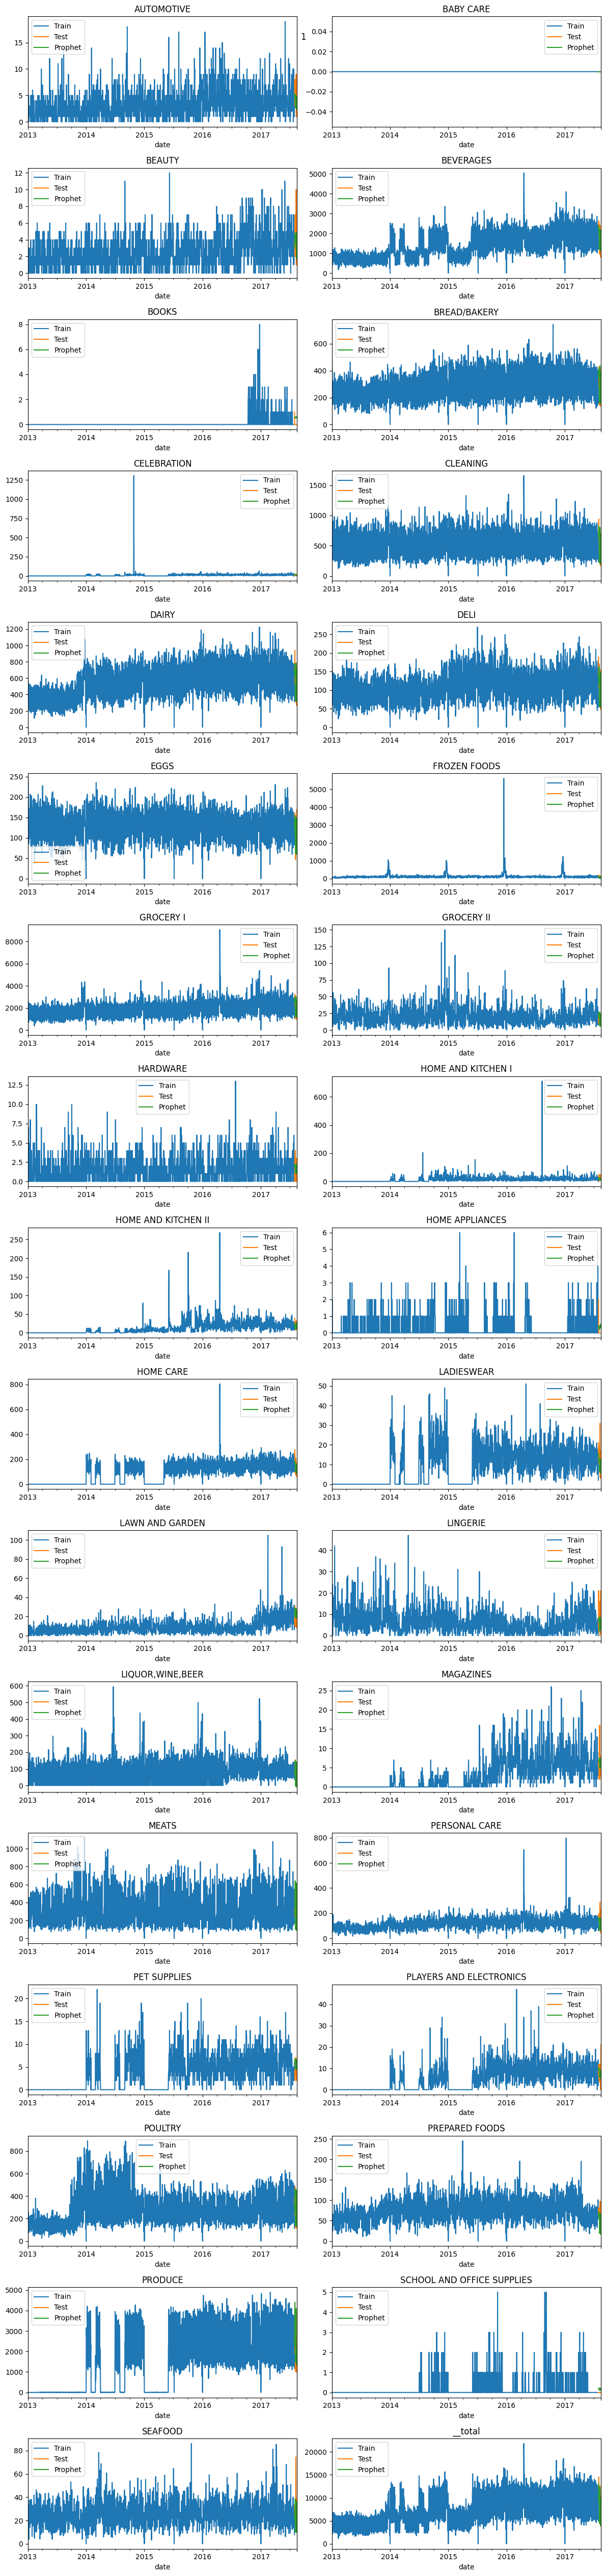

In [109]:
plot_series_for_given_level(1, y_train, y_test, {"Prophet" : y_pred})

In [110]:
from sktime.transformations.hierarchical.reconcile import Reconciler

reconciler = Reconciler()
y_pred_reconciled = reconciler.fit_transform(y_pred)
y_pred_reconciled.head()

sales
store_nbr family     date                
1         AUTOMOTIVE 2017-07-31  4.728044
                     2017-08-01  5.293555
                     2017-08-02  4.923126
                     2017-08-03  4.419014
                     2017-08-04  5.136996

In [111]:
from sktime.performance_metrics.forecasting import MeanSquaredError

metric = MeanSquaredError()
metric(y_true=y_test, y_pred=y_pred_reconciled)

5024904.351135348